In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as m
import random
import statsmodels.api as sm
import pandas_datareader.data as pdr
import yfinance as yf
from datetime import date
import seaborn as sns
import scipy.stats as si
from pylab import mpl, plt
from scipy.stats import norm, mvn
from statsmodels.compat.pandas import deprecate_kwarg
from statsmodels.graphics import utils
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Data Obtaining and Time Series

- We start by collecting the data of our underlying asset (Netflix stock) from https://finance.yahoo.com/quote/NFLX?p=NFLX&.tsrc=fin-srch for a 5 years period.
- Afterwards, we calculate the log returns that will be used to study wether the time-series of the underlying follows a geometric Brownian Motion for different time intervals (1, 2 and 5 years).
- To conclude, we plot the prices of the stock and obtain the time-series for the entire period.

In [2]:
start_date=date(2018,7,14)
end_date=date.today()

In [3]:
netflix = yf.download('NFLX', start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [4]:
netflix.drop(columns=['High', 'Low', 'Open', 'Close', 'Volume'], inplace=True)

In [5]:
netflix.rename(columns = {'Adj Close':'NFLX'}, inplace = True)

In [6]:
netflix

,NFLX
Date,
2018-07-16,400.480011
2018-07-17,379.480011
2018-07-18,375.130005
2018-07-19,364.230011
2018-07-20,361.049988
...,...
2023-06-30,440.489990
2023-07-03,441.440002
2023-07-05,445.899994


In [7]:
netflix_1year=netflix.tail(252)
netflix_1year

,NFLX
Date,
2022-07-07,189.270004
2022-07-08,186.979996
2022-07-11,177.339996
2022-07-12,174.449997
2022-07-13,176.559998
...,...
2023-06-30,440.489990
2023-07-03,441.440002
2023-07-05,445.899994


In [8]:
netflix_2years=netflix.tail(504)
netflix_2years

,NFLX
Date,
2021-07-07,535.960022
2021-07-08,530.760010
2021-07-09,535.979980
2021-07-12,537.309998
2021-07-13,540.679993
...,...
2023-06-30,440.489990
2023-07-03,441.440002
2023-07-05,445.899994


In [9]:
log_returns = np.log(netflix/netflix.shift(1)).dropna()

In [10]:
log_returns

,NFLX
Date,
2018-07-17,-0.053862
2018-07-18,-0.011529
2018-07-19,-0.029487
2018-07-20,-0.008769
2018-07-23,0.004449
...,...
2023-06-30,0.028204
2023-07-03,0.002154
2023-07-05,0.010053


In [11]:
log_returns_1year=log_returns.tail(252)
log_returns_1year

,NFLX
Date,
2022-07-07,0.027913
2022-07-08,-0.012173
2022-07-11,-0.052933
2022-07-12,-0.016431
2022-07-13,0.012023
...,...
2023-06-30,0.028204
2023-07-03,0.002154
2023-07-05,0.010053


In [12]:
log_returns_2years=log_returns.tail(504)
log_returns_2years

,NFLX
Date,
2021-07-07,-0.010542
2021-07-08,-0.009750
2021-07-09,0.009787
2021-07-12,0.002478
2021-07-13,0.006252
...,...
2023-06-30,0.028204
2023-07-03,0.002154
2023-07-05,0.010053


<AxesSubplot:title={'center':'Netflix Price development'}, xlabel='Time', ylabel='Price'>

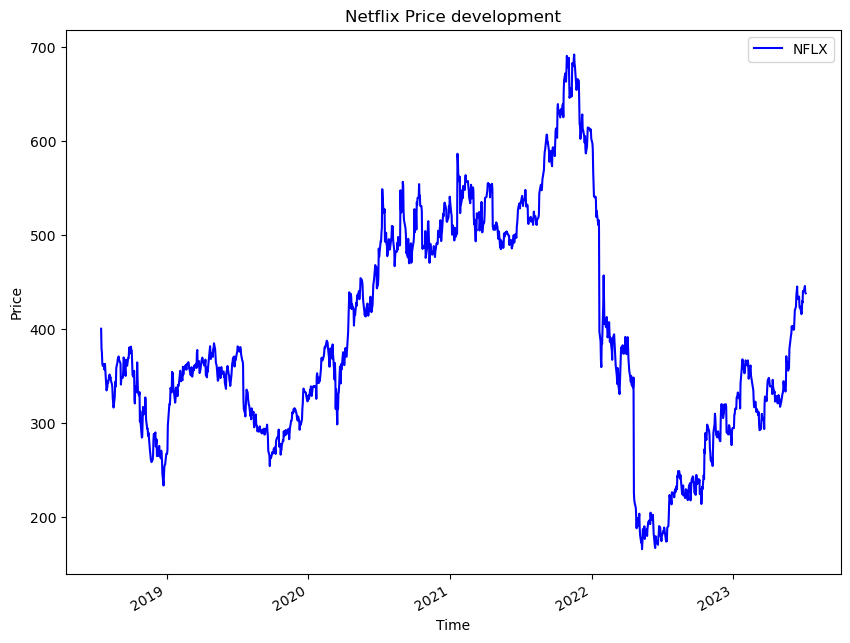

In [13]:
netflix.plot(xlabel='Time', ylabel='Price',figsize=(10,8), subplots=False, grid=False, colormap='winter', 
             title='Netflix Price development')

# Monte Carlo Simulation

- We begin by determining the yearly mean and yearly volatility of the log returns for the three different periods.
- Then, we define the variables used for carrying out the Monte Carlo simulation (again for each time interval): S0 (current price), r (risk-free rate), sigma (volatility), T (time horizon in years), M (number of time intervals) and I (number of simulated processes).
- Thereafter, We define the function generate_gbm_paths through which random paths can be created for obtaining a geometric Brownian Motion.
- In the end, we plot the simulated paths obtained for the 1, 2 and 5 years periods.

In [14]:
mean_1year = log_returns_1year.mean()*252
volatility_1year = log_returns_1year.std()*m.sqrt(252)
mean_2years = log_returns_2years.mean()*252
volatility_2years = log_returns_2years.std()*m.sqrt(252)
mean_5years = log_returns.mean()*252
volatility_5years = log_returns.std()*m.sqrt(252)
table1 = pd.DataFrame()
table1["1 Year Mean"] = mean_1year
table1["1 Year Volatility"] = volatility_1year
table1["2 Years Mean"] = mean_2years
table1["2 Years Volatility"] = volatility_2years
table1["5 Years Mean"] = mean_5years
table1["5 Years Volatility"] = volatility_5years
table1

,1 Year Mean,1 Year Volatility,2 Years Mean,2 Years Volatility,5 Years Mean,5 Years Volatility
NFLX,0.867185,0.470041,-0.106077,0.57471,0.018071,0.487668


In [15]:
S0 = 417.079987 
r = 0.05
sigma_1 = 0.473917
sigma_2 = 0.574162
sigma_5 = 0.488608
T_1 = 1
T_2 = 2
T_5 = 5
M = 100
I = 250000
np.random.seed(1000)

In [16]:
def generate_gbm_paths(S0, r, sigma, T, M, I):
    dt = T / M
    paths = np.zeros((M + 1, I))
    paths[0] = S0
    
    for t in range(1, M + 1):
        rand = np.random.standard_normal(I)
        rand = (rand - rand.mean()) / rand.std()
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * m.sqrt(dt) * rand)
        
    return paths

In [17]:
paths_1 = generate_gbm_paths(S0, r, sigma_1, T_1, M, I)
paths_2 = generate_gbm_paths(S0, r, sigma_2, T_2, M, I)
paths_5 = generate_gbm_paths(S0, r, sigma_5, T_5, M, I)

In [18]:
expected_value_1year = S0 * m.exp(r * T_1)
expected_value_1year

438.4641352099879

In [19]:
expected_value_2years = S0 * m.exp(r * T_2)
expected_value_2years

460.94467214376925

In [20]:
expected_value_5years = S0 * m.exp(r * T_5)
expected_value_5years

535.5413040997928

In [21]:
average_sim_value_1year = paths_1[-1].mean()
average_sim_value_1year

438.42866859528766

In [22]:
average_sim_value_2years = paths_2[-1].mean()
average_sim_value_2years

461.95351129237866

In [23]:
average_sim_value_5years = paths_5[-1].mean()
average_sim_value_5years

536.8659127138988

Text(0.5, 1.0, '1 Year gBM')

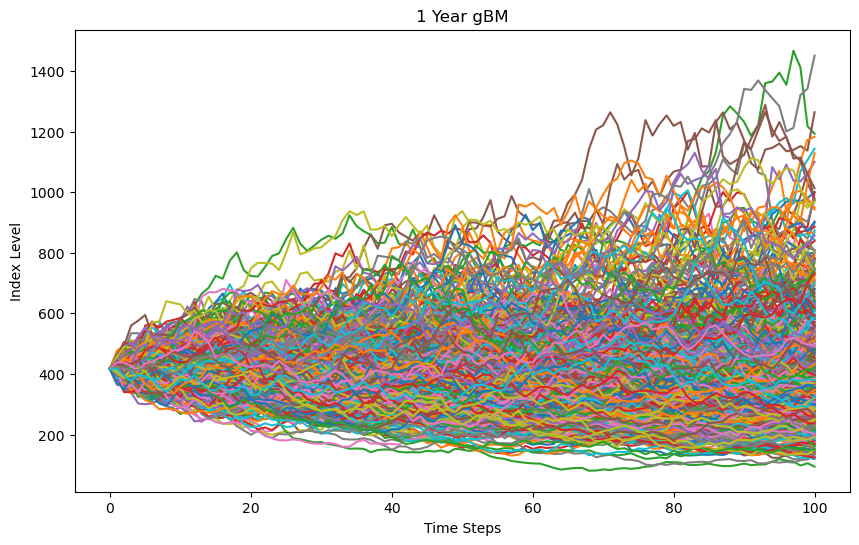

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(paths_1[:, :500])
plt.xlabel('Time Steps')
plt.ylabel('Index Level')
plt.title('1 Year gBM')

Text(0.5, 1.0, '2 Years gBM')

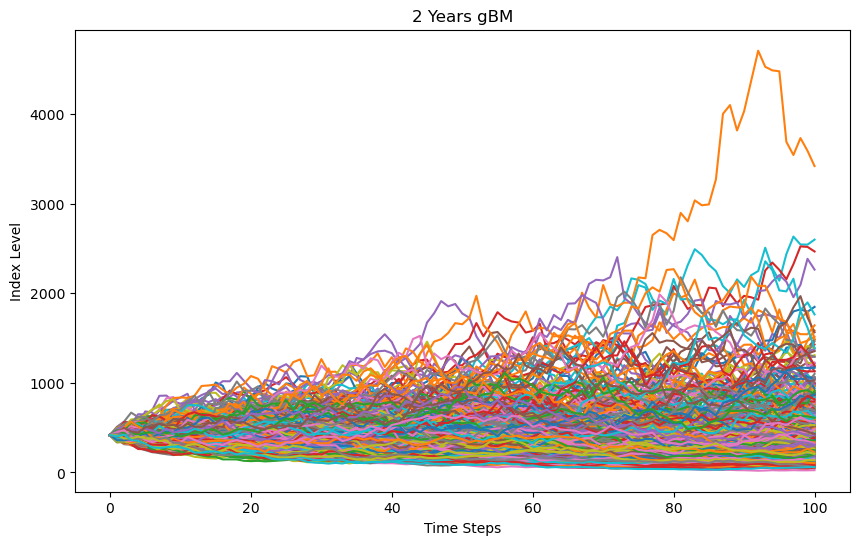

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(paths_2[:, :500])
plt.xlabel('Time Steps')
plt.ylabel('Index Level')
plt.title('2 Years gBM')

Text(0.5, 1.0, '5 Years gBM')

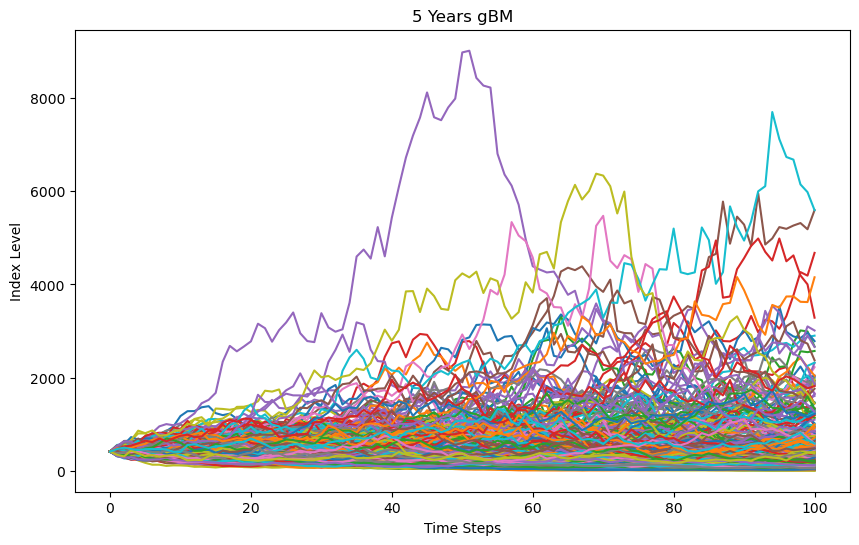

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(paths_5[:, :500])
plt.xlabel('Time Steps')
plt.ylabel('Index Level')
plt.title('5 Years gBM')

# Geometric Brownian Motion Analysis

In this part of the code, we develop several tests for our data to determine if the time-series of the underlying asset follows a geometric Brownian Motion. It is possible to state that a set of data that is normally distributed follows a geometric Brownian Motion, therefore, we have tried to understand whether our historical log returns are.
- Log returns histogram: we plot the histogram of the log returns combined with the normal density function. If the histogram is bell shaped and follows the PDF function, then we could confirm to have a normal distribution.
- Normality test: we obtain some statistical features of our data, such as the Skewness and the Kurtosis. For the measurements to be normally distributed, their values of Skewness and Kurtosis should be equal or close to 0; furthermore, to understand whether these results are reliable, the p-values should be higher than the 5% level (to carry out this test, we have used the code coming from the lecture of Prof. Lukas on the 15th of June 2023).
- Autocorrelation function (ACF) and partial autocorrelation function (PACF): through these two graphs, it is possible to study the correlation between current and past values in order to understand which of the past data can be more useful to make a prediction of future ones. It is possible to observe the relationship between the lags: if they change suddenly from one to the next, this would show the absence of correlation; on the other hand, if the lags are more stable, there would be a stronger relationship.

In [27]:
m1d_1=np.mean(log_returns_1year['NFLX'])
m1a_1=m1d_1*252

s1d_1=np.std(log_returns_1year['NFLX'])
s1a_1=s1d_1*np.sqrt(252)

m1d_2=np.mean(log_returns_2years['NFLX'])
m1a_2=m1d_2*252

s1d_2=np.std(log_returns_2years['NFLX'])
s1a_2=s1d_2*np.sqrt(252)

m1d_5=np.mean(log_returns['NFLX'])
m1a_5=m1d_5*252

s1d_5=np.std(log_returns['NFLX'])
s1a_5=s1d_5*np.sqrt(252)

<Figure size 1000x600 with 0 Axes>

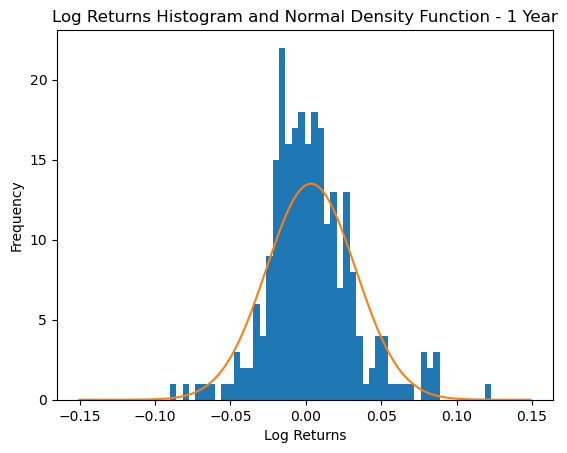

<Figure size 1000x600 with 0 Axes>

In [28]:
binN=50

x1 = np.arange(-0.15, 0.15, 0.001) 
plt.hist(log_returns_1year['NFLX'], bins=binN)
plt.plot(x1, norm.pdf(x1, m1d_1,s1d_1))
plt.title('Log Returns Histogram and Normal Density Function - 1 Year')
plt.xlabel('Log Returns')
plt.ylabel('Frequency')
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

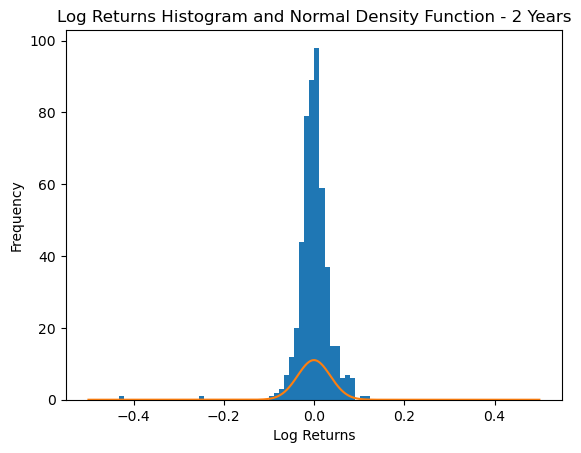

<Figure size 1000x600 with 0 Axes>

In [29]:
x2 = np.arange(-0.50, 0.50, 0.001) 
plt.hist(log_returns_2years['NFLX'], bins=binN)
plt.plot(x2, norm.pdf(x2, m1d_2,s1d_2))
plt.title('Log Returns Histogram and Normal Density Function - 2 Years')
plt.xlabel('Log Returns')
plt.ylabel('Frequency')
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

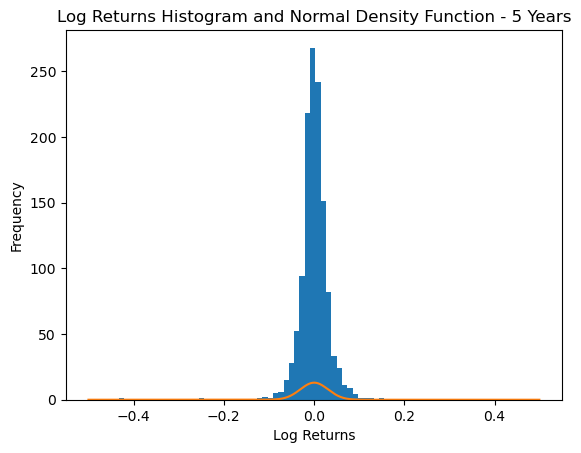

<Figure size 1000x600 with 0 Axes>

In [30]:
x3 = np.arange(-0.50, 0.50, 0.001) 
plt.hist(log_returns['NFLX'], bins=binN)
plt.plot(x3, norm.pdf(x3, m1d_5,s1d_5))
plt.title('Log Returns Histogram and Normal Density Function - 5 Years')
plt.xlabel('Log Returns')
plt.ylabel('Frequency')
plt.figure(figsize=(10, 6))

In [31]:
def normality_tests(arr):
    print('Skew of data set %14.3f' % si.skew(arr))
    print('Skew test p-value %14.3f' % si.skewtest(arr)[1])
    print('Kurt of data set %14.3f' % si.kurtosis(arr))
    print('Kurt test p-value %14.3f' % si.kurtosistest(arr)[1])
    print('Norm test p-value %14.3f' % si.normaltest(arr)[1])

In [32]:
normality_tests(log_returns_1year.to_numpy().flatten())

Skew of data set          0.570
Skew test p-value          0.000
Kurt of data set          1.784
Kurt test p-value          0.000
Norm test p-value          0.000


In [33]:
normality_tests(log_returns_2years.to_numpy().flatten())

Skew of data set         -3.712
Skew test p-value          0.000
Kurt of data set         43.477
Kurt test p-value          0.000
Norm test p-value          0.000


In [34]:
normality_tests(log_returns.to_numpy().flatten())

Skew of data set         -2.453
Skew test p-value          0.000
Kurt of data set         35.300
Kurt test p-value          0.000
Norm test p-value          0.000


C:\Users\anghi\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0.5, 1.0, 'Partial Autocorrelation of Netflix (5 Years)')

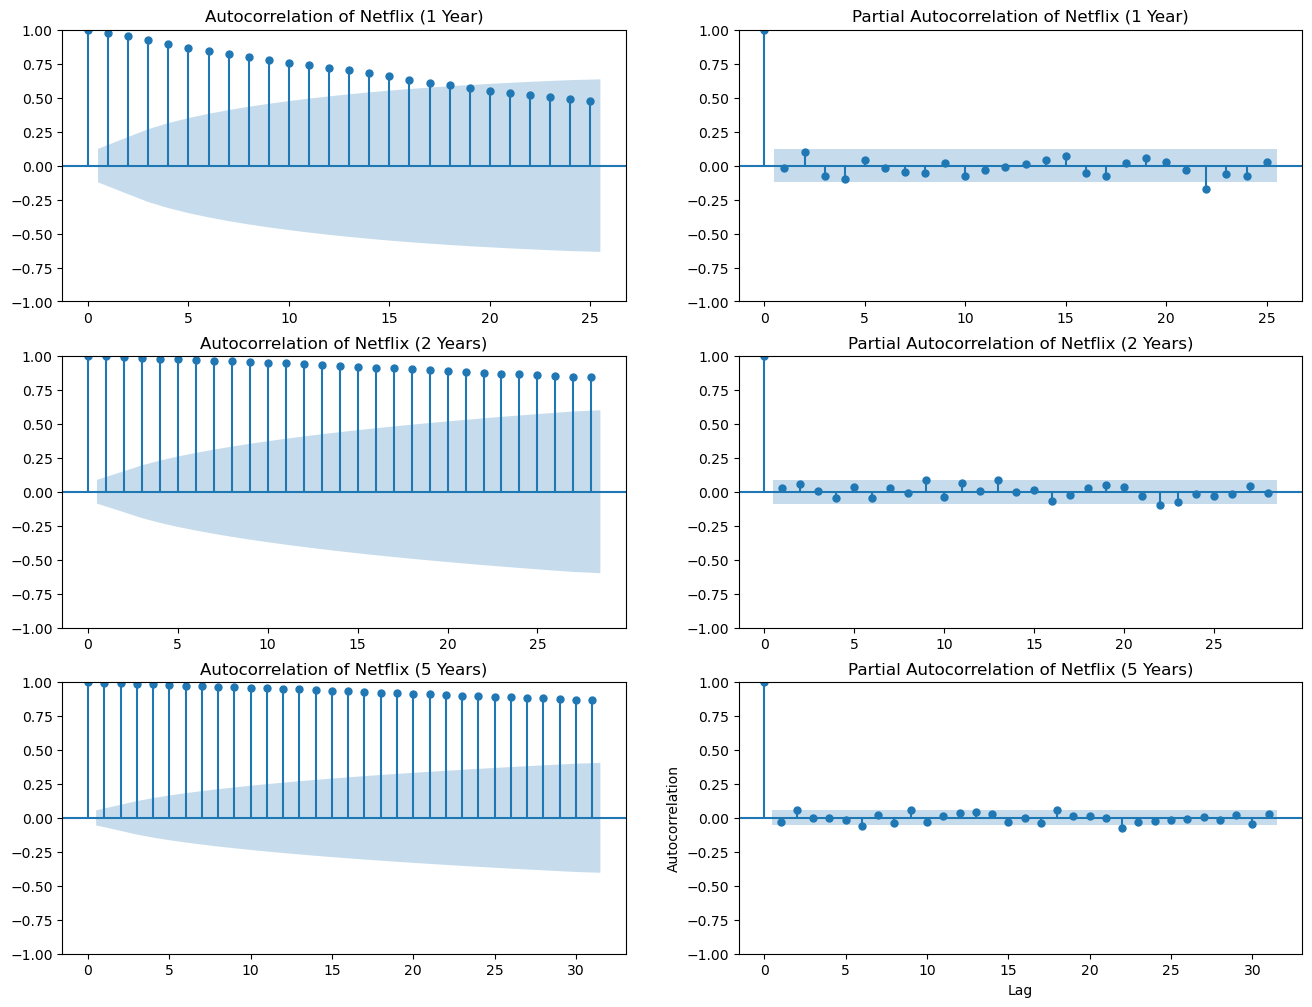

In [35]:
fig, axes = plt.subplots(3,2, figsize = (16,12))
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plot_acf(netflix_1year.NFLX, ax = axes[0,0])
axes[0,0].set_title('Autocorrelation of Netflix (1 Year)')

plot_acf(netflix_2years.NFLX, ax = axes[1,0])
axes[1,0].set_title('Autocorrelation of Netflix (2 Years)')

plot_acf(netflix.NFLX, ax = axes[2,0])
axes[2,0].set_title('Autocorrelation of Netflix (5 Years)')

plot_pacf(log_returns_1year.NFLX, ax = axes[0,1])
axes[0,1].set_title('Partial Autocorrelation of Netflix (1 Year)')

plot_pacf(log_returns_2years.NFLX, ax = axes[1,1])
axes[1,1].set_title('Partial Autocorrelation of Netflix (2 Years)')

plot_pacf(log_returns.NFLX, ax = axes[2,1])
axes[2,1].set_title('Partial Autocorrelation of Netflix (5 Years)')

The results obtained from the tests demonstrate the absence of a normal distribution in our data for the following reasons:
- The log returns histograms do not have a bell shape and they do not follow the normal density function for any of the three time intervals.
- The normality tests show the presence of Skewness for the 1 year data, but not for the 2 and 5 years; despite that, Kurtosis is strongly present in all the three periods.
- The ACF plots show that the lags do not remain inside the range near 0; while, the PACF plots show a more stable distribution. This last result is not enough to confirm the presence of normality given the fact that all the other tests done demonstrate the opposite.

In order to carry out the last part of the code where we have developed the Black Model for options valuation, we have to assume that our data are normally distributed.

## Black Model (1976)

In 1976, the American economist Fischer Black demonstrated how the Black-Scholes model could be modified in order to value European call or put options on futures contracts. In this model, Black describes the futures' price of a commodity as the price at which we can agree to buy or sell it at a given time in the future without putting up any money now.
The following formulas are used in the Black model to obtain the price of a call or put option:
- $c = e^{-rT}[FN(d_{1}) - KN(d_{2})]$
- $p = e^{-rT}[KN(-d_{2}) - FN(-d_{1})]$
- $d_{1} = \frac{\ln(F/K)+(\sigma^{2}/2)T}{\sigma \sqrt{T}}$
- $d_{2} = \frac{\ln(F/K)-(\sigma^{2}/2)T}{\sigma \sqrt{T}}$

The variables used to define the Black model are the following:
- option_type: either call ("c") or put ("p");
- fs: underlying's price;
- x: strike price;
- t: time horizon (in years);
- r: risk-free rate;
- v: volatility.

In [36]:
def _gbs(option_type, fs, x, t, r, v):
    t__sqrt = m.sqrt(t)
    d1 = (m.log(fs / x) + ((v * v) / 2) * t) / (v * t__sqrt)
    d2 = d1 - v * t__sqrt
    
    if option_type == "c":
        value = fs * m.exp(- r * t) * norm.cdf(d1) - x * m.exp(-r * t) * norm.cdf(d2)
    
    else:
        value = x * m.exp(-r * t) * norm.cdf(-d2) - (fs * m.exp(- r * t) * norm.cdf(-d1))
    
    return value

In [37]:
def black_76(option_type, fs, x, t, r, v):
    return _gbs(option_type, fs, x, t, r, v)

In [38]:
black_76('p', fs=S0, x=180, t=1, r=0.05, v=sigma_5)
c = black_76('p', fs=S0, x=180, t=1, r=0.05, v=sigma_5)
print( c )

2.169413490735879


In [39]:
black_76('c', fs=S0, x=260, t=1, r=0.05, v=sigma_5)
b = black_76('c', fs=S0, x=260, t=1, r=0.05, v=sigma_5)
print(b)

162.73511414398746


It is possible to check the option prices for Netflix on https://finance.yahoo.com/quote/NFLX/options?p=NFLX&date=1718928000. The call price with strike price of 260 present there is equal to 161.85, which is different from ours just by 0.55%; regarding the put price, the one in Yahoo Finance for a strike price of 180 is equal to 1.99, again slightly different from ours by 9% (as of July 10th 2023).

## List of References

- https://finance.yahoo.com/
- https://towardsdatascience.com/time-series-from-scratch-autocorrelation-and-partial-autocorrelation-explained-1dd641e3076f
- https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
- https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
- https://towardsdatascience.com/time-series-decomposition-and-statsmodels-parameters-69e54d035453
- https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
- https://sites.google.com/view/vinegarhill-financelabs/black-1976
- Yves J. Hilpisch (2018). Python for Finance. O'Reilly.